In [8]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

from base import supres, BaseStrategy
from exputils import *

# Load Data

In [9]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'

In [10]:
pairs = pd.read_csv('selected-pairs.tsv', header=None)[0].tolist()
train_dict = {pair: read_train(pair, dropbox_dir) for pair in pairs}

# Experiment setup

In [11]:
from itertools import product


features = ['support']
window_sizes = [4, 6, 8, 12, 24, 30, 48]

stop_losses = [round(i / 100, 2) for i in range(1, 6)]
returns = [-round(i / 100, 2) for i in range(1, 6)]
loss_percentages = [round(i / 10, 1) for i in range(1, 11)]

args = product(pairs, window_sizes, stop_losses, returns, loss_percentages)
args = list(args)
len(args)

33250

# Try params

In [12]:
supports_for_data_dict = load_model('ohlc_supports_train.pkl')

In [13]:
def trading_stats(data, pair, willing_loss, _return, loss_percentage):
    contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
    dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
    wallet = {'btc': 100}
    exchange = BackTestExchange(dm, wallet, 0.0025)
    strategy = BaseStrategy(exchange, 
                            dm, 
                            contract_pair, 
                            willing_loss=willing_loss,  
                            target_return=_return,
                            loss_percentage=loss_percentage)
    strategy.trade()
    strategy_stats = strategy.stats(contract_pair['priceContract']).report()
    return strategy_stats


def trading_stats_f(args):
    pair, window_size, stop_loss, _return, loss_percentage = args
    
    data = train_dict[pair]
    data['support'] = supports_for_data_dict[pair][window_size]
    stats = trading_stats(data, pair, stop_loss, _return, loss_percentage)
    return pair, window_size, stop_loss, _return, loss_percentage, stats

In [17]:
results = run_parallel(trading_stats_f, args)

param_cols = ['pair', 'window_size', 'stop_loss', '_return', 'loss_percentage']
stats_cols = ['startAmount', 'numberOfTrades', 'totalProfit', 'avgProfit',
    'winPercentage', 'avgWinTrade', 'avgLossTrade', 'profitFactor',
    'maxDrawdown', 'avgTimeToClose', 'minTimeToClose', 'maxTimeToClose']

result_df = pd.DataFrame(results, columns=param_cols+['stats'])

for c in stats_cols:
    result_df[c] = result_df['stats'].apply(lambda x: x.iloc[:, 0][c])
    
result_df = result_df.drop('stats', axis=1)

rpath = os.path.join(dropbox_dir,'result', 'base-strategy3-learn-01.pkl')
result_df.to_pickle(rpath)

In [16]:
result_df

,pair,window_size,stop_loss,_return,loss_percentage,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,avgTimeToClose,minTimeToClose,maxTimeToClose
0,BTC_ETH,4,0.0300,-0.0100,0.6000,100.0000,636.0000,317.2757,0.4989,77.2013,1.3695,-2.4494,1.8933,13.5477,8.2013,0.2500,139.2500
1,BTC_ETH,4,0.0300,-0.0100,0.7000,100.0000,636.0000,326.9705,0.5141,78.6164,1.3549,-2.5770,1.9329,12.1241,7.9807,0.2500,137.2500
2,BTC_ETH,4,0.0300,-0.0100,0.9000,100.0000,636.0000,369.0924,0.5803,80.0314,1.4040,-2.7208,2.0682,10.7531,7.7213,0.2500,137.2500
3,BTC_ETH,4,0.0300,-0.0100,0.3000,100.0000,636.0000,360.9946,0.5676,70.9119,1.6437,-2.0557,1.9492,13.8532,9.1030,0.2500,158.0000
4,BTC_ETH,4,0.0300,-0.0100,0.4000,100.0000,636.0000,330.4493,0.5196,73.4277,1.5031,-2.1981,1.8896,14.4236,8.7932,0.2500,145.0000
5,BTC_ETH,4,0.0300,-0.0100,0.5000,100.0000,636.0000,322.0682,0.5064,75.4717,1.4296,-2.3342,1.8845,14.4421,8.4961,0.2500,145.0000
6,BTC_ETH,4,0.0300,-0.0100,0.8000,100.0000,636.0000,337.6060,0.5308,79.5597,1.3523,-2.6666,1.9739,11.7899,7.8349,0.2500,137.2500
7,BTC_ETH,4,0.0300,-0.0100,0.2000,100.0000,635.0000,373.1174,0.5876,66.4567,1.8103,-1.8349,1.9547,13.1777,9.4626,0.2500,160.0000
8,BTC_ETH,4,0.0300,-0.0100,0.1000,100.0000,635.0000,375.0638,0.5907,59.3701,2.1044,-1.6212,1.8967,12.3246,9.8028,0.2500,179.2500
9,BTC_ETH,4,0.0300,-0.0100,1.0000,100.0000,636.0000,388.1666,0.6103,81.2893,1.4054,-2.8438,2.1470,8.8247,7.6435,0.2500,137.2500


# Tmp

In [35]:
from modeling.strategy import Strategy

In [36]:
def trading_stats2(data, pair, willing_loss, _return, loss_percentage):
    contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
    dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
    wallet = {'btc': 100}
    exchange = BackTestExchange(dm, wallet, 0.0025)
    strategy = BaseStrategy(exchange, 
                            dm, 
                            contract_pair, 
                            willing_loss=willing_loss,  
                            target_return=_return,
                            loss_percentage=loss_percentage)
    strategy.trade()
    strategy_stats = strategy.stats(contract_pair['priceContract'])
    return strategy, strategy_stats

In [7]:
pair = 'BTC_ETH'
data = train_dict[pair]
data['support'] = supports_for_data_dict[pair][4]
willing_loss = .02
_return = -0.05
loss_percentage = 0.1

NameError: name 'supports_for_data_dict' is not defined

In [40]:
%%timeit

strategy, stats = trading_stats2(data, pair, willing_loss, _return, loss_percentage)
stats.report()

463 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%prun

strategy, stats = trading_stats2(data, pair, willing_loss, _return, loss_percentage)
stats.report()

         321807 function calls (320965 primitive calls) in 0.553 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.350    0.350    0.543    0.543 <ipython-input-35-d465e5be4fa3>:20(trade)
   140352    0.153    0.000    0.153    0.000 dataManager.py:38(tick)
   140353    0.023    0.000    0.023    0.000 dataManager.py:50(has_tick)
     8696    0.005    0.000    0.005    0.000 strategy.py:19(current_return)
      364    0.002    0.000    0.002    0.000 {built-in method builtins.round}
     4375    0.002    0.000    0.005    0.000 strategy.py:16(is_risky)
     4321    0.002    0.000    0.004    0.000 strategy.py:38(is_target_satisfied)
  916/184    0.001    0.000    0.003    0.000 copy.py:132(deepcopy)
       91    0.001    0.000    0.003    0.000 exchange.py:25(buy)
     1444    0.000    0.000    0.001    0.000 {built-in method builtins.isinstance}
     1411    0.000    0.000    0.000    0.000 {built-in method bu

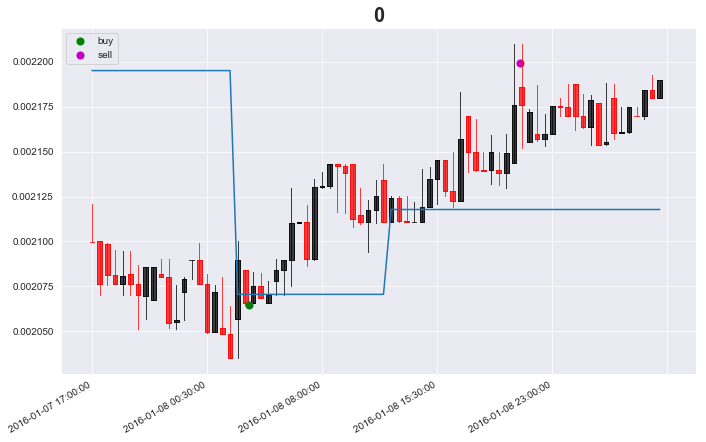

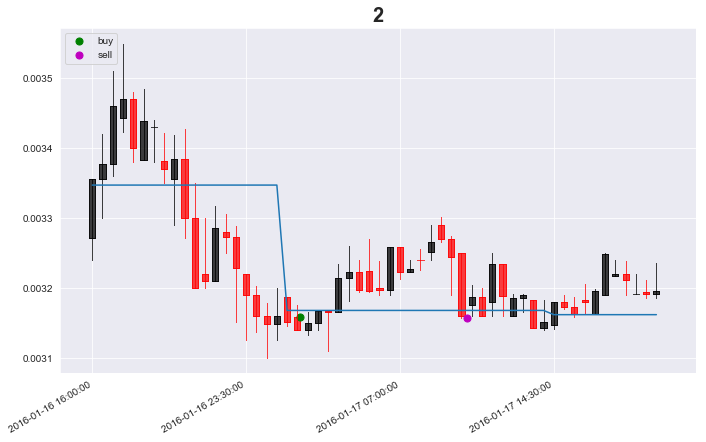

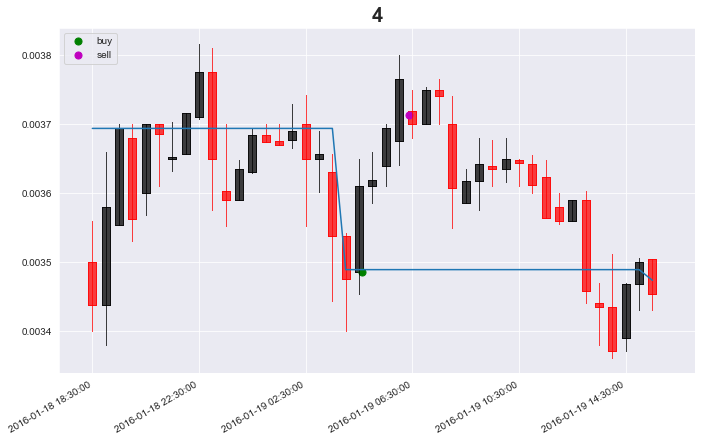

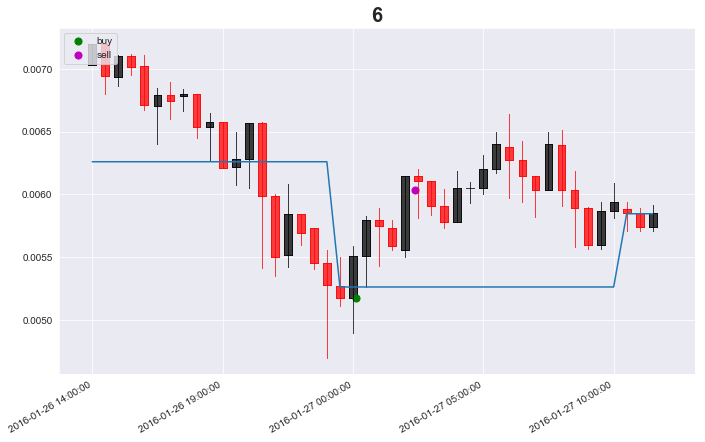

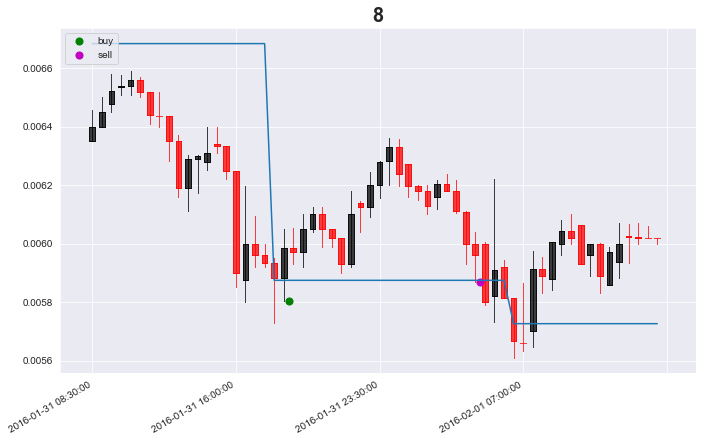

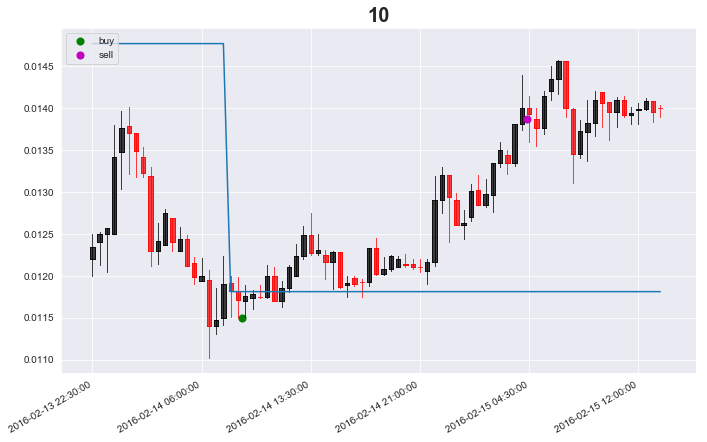

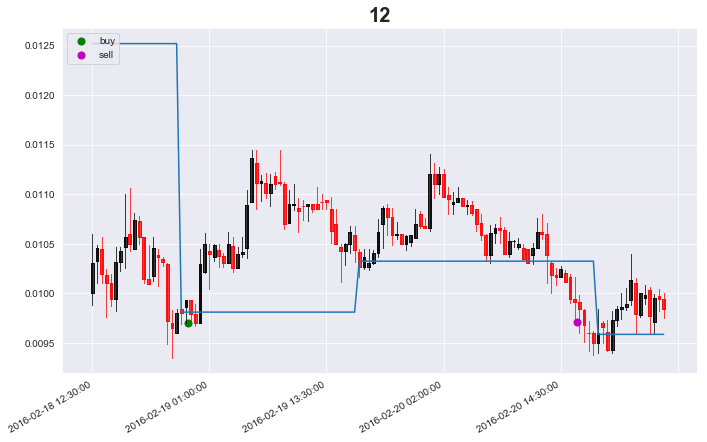

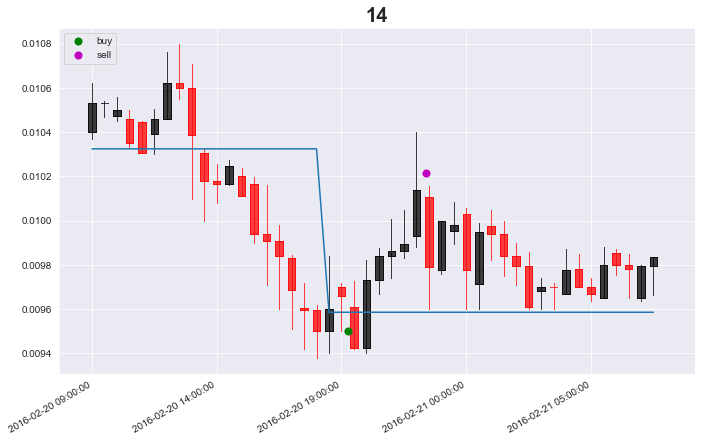

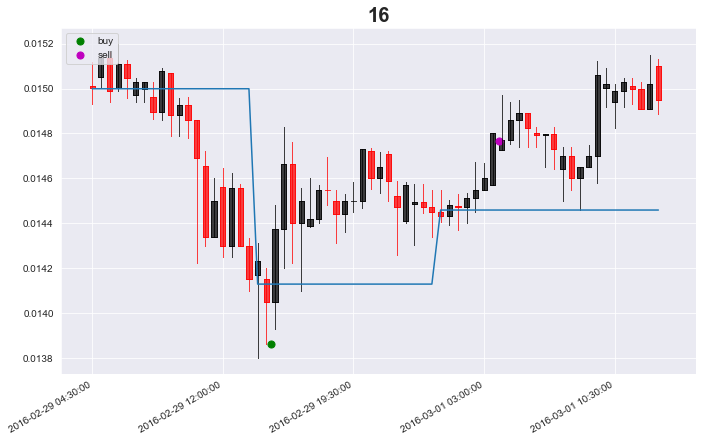

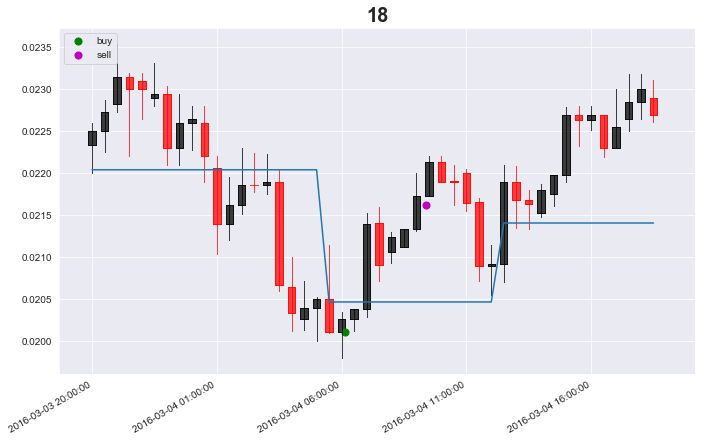

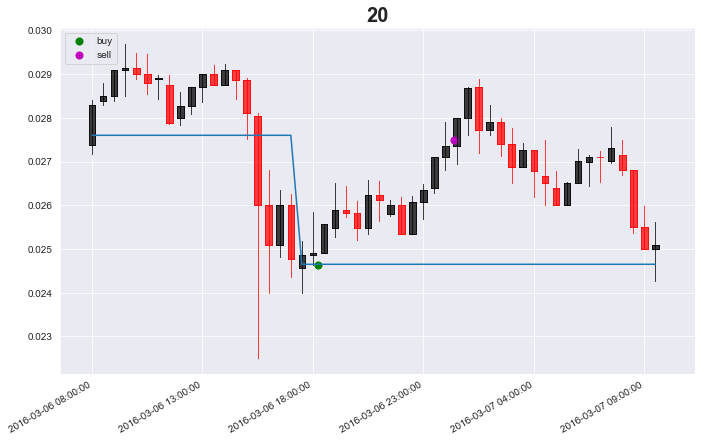

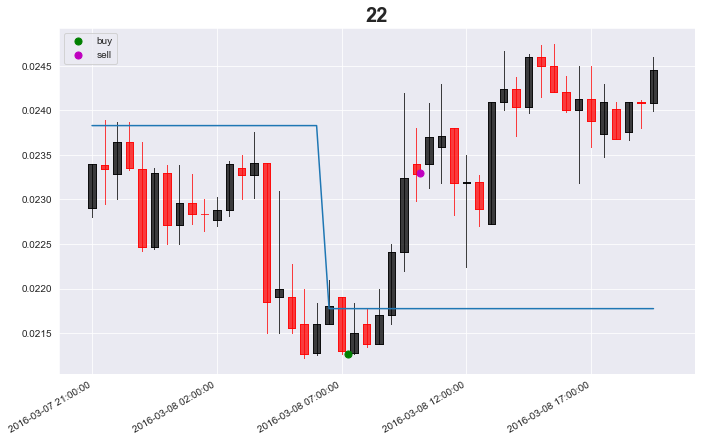

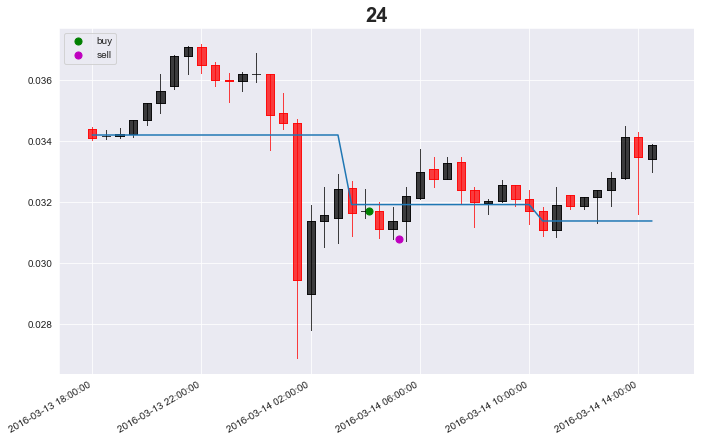

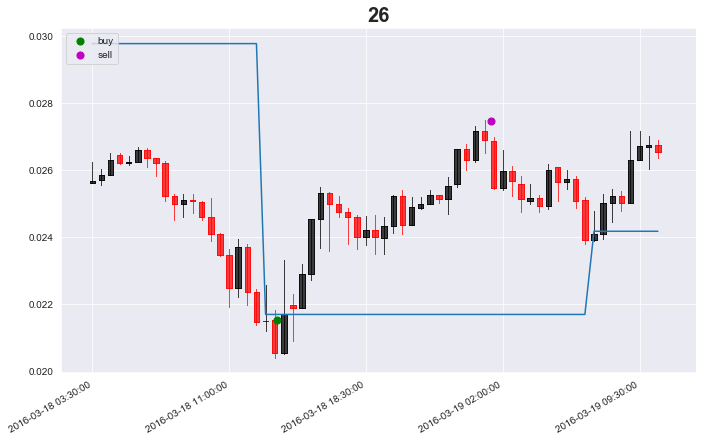

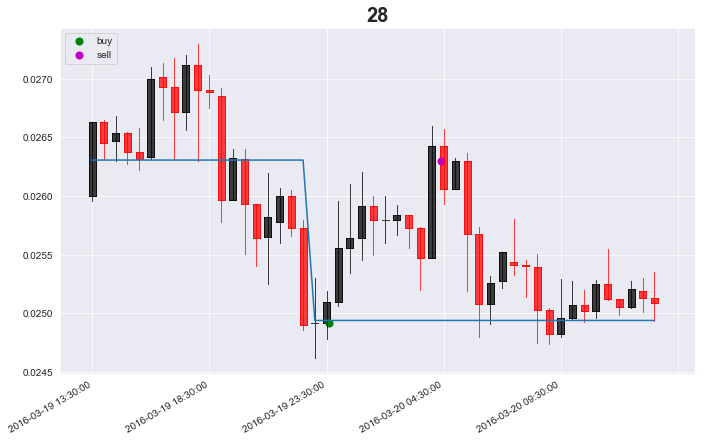

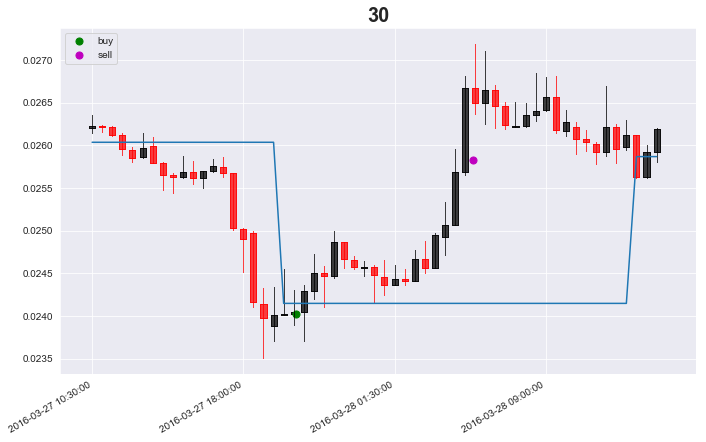

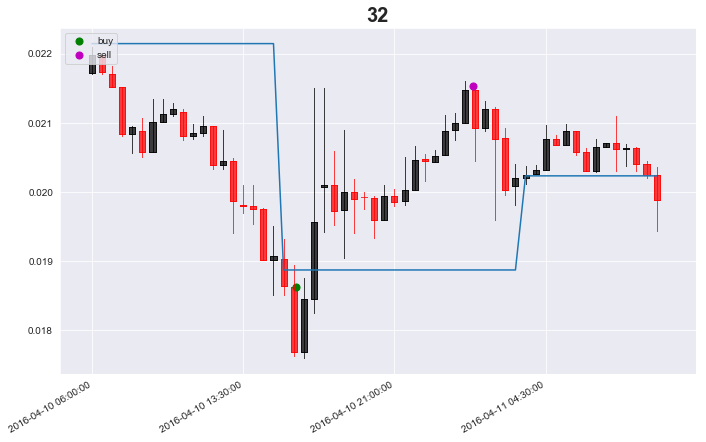

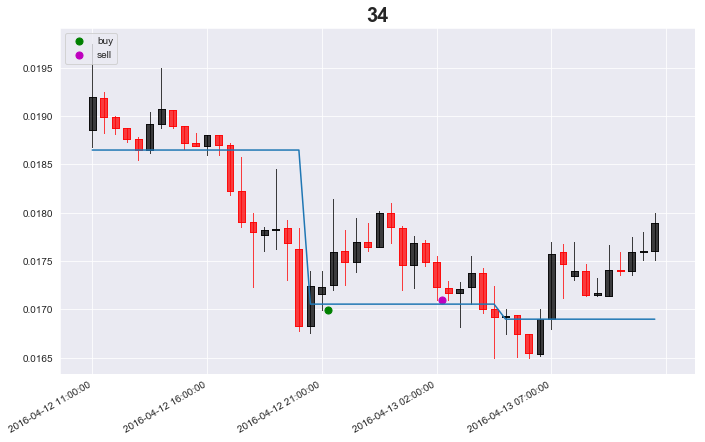

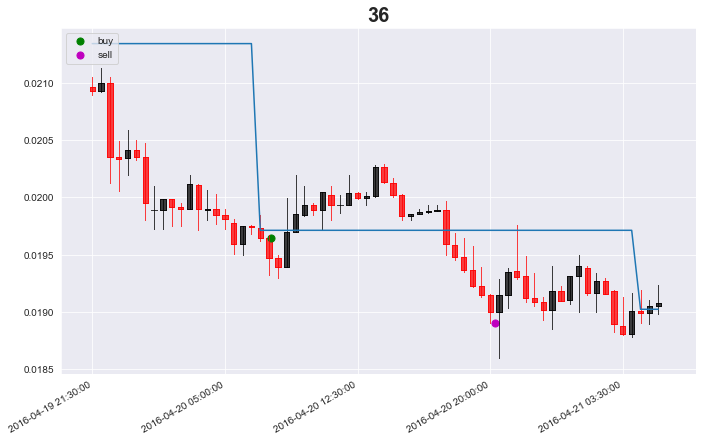

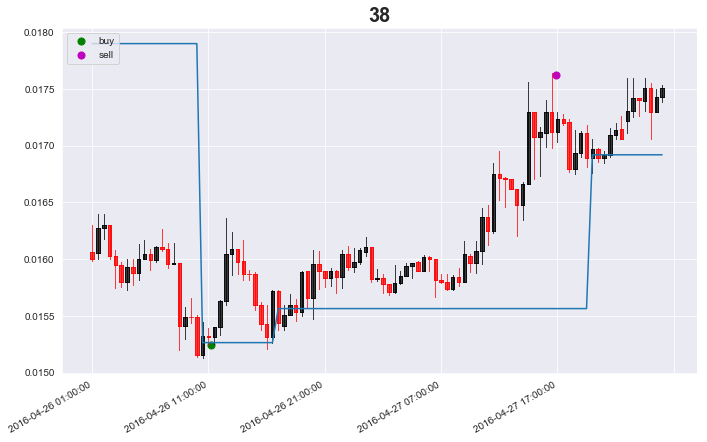

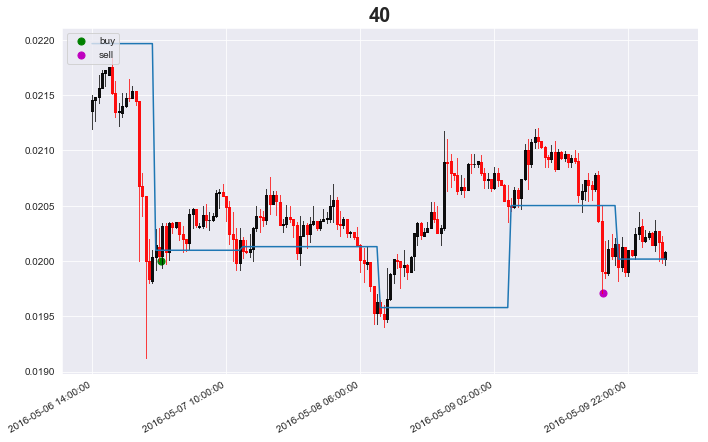

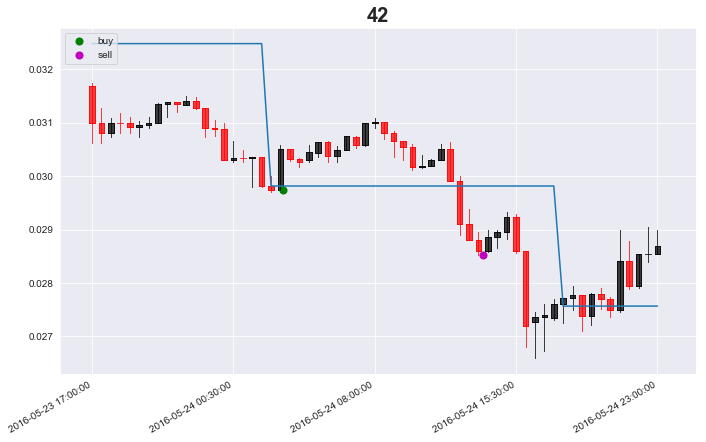

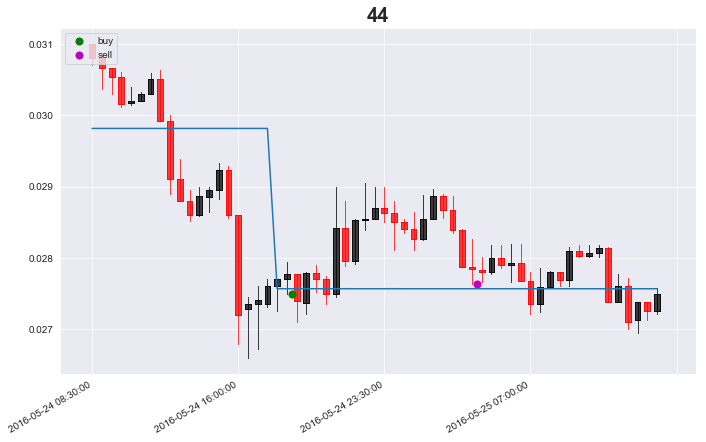

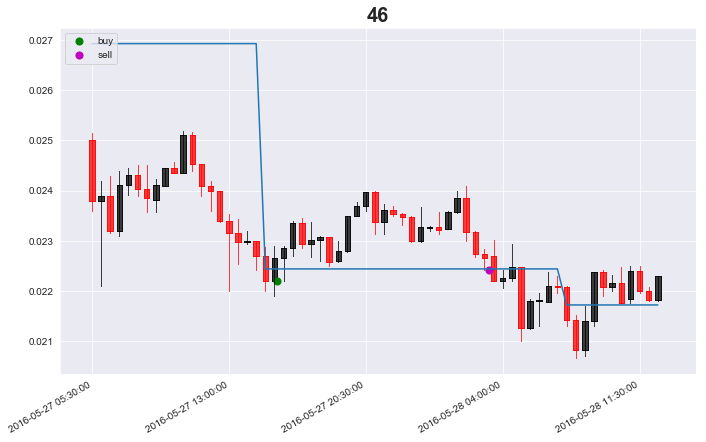

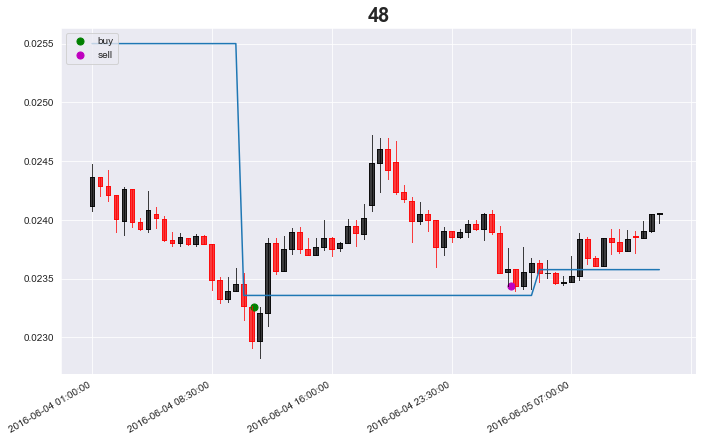

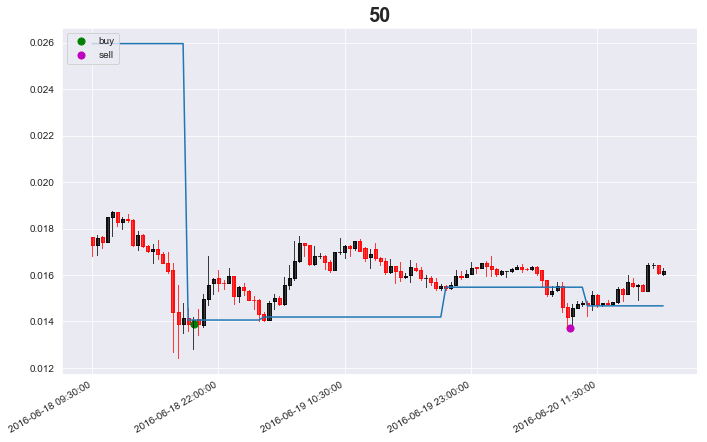

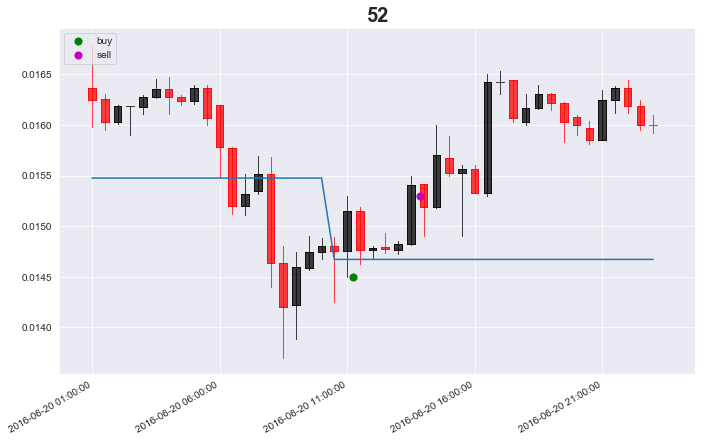

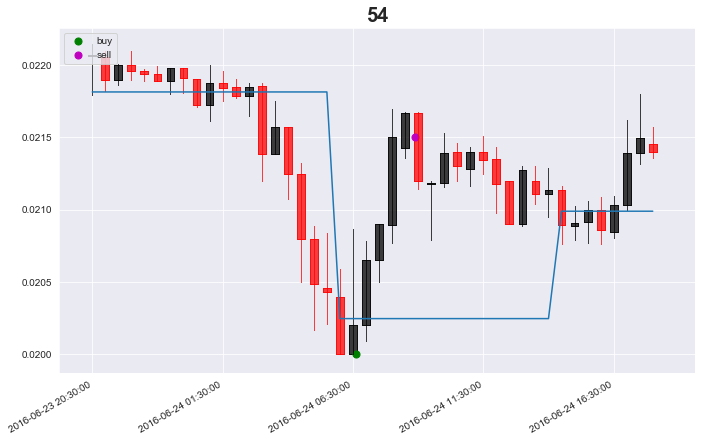

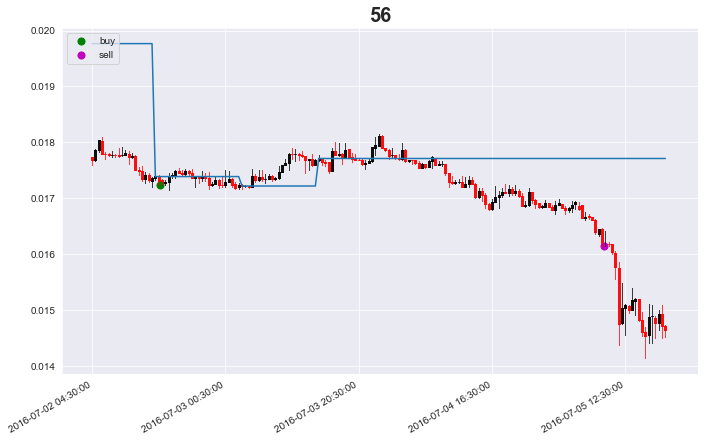

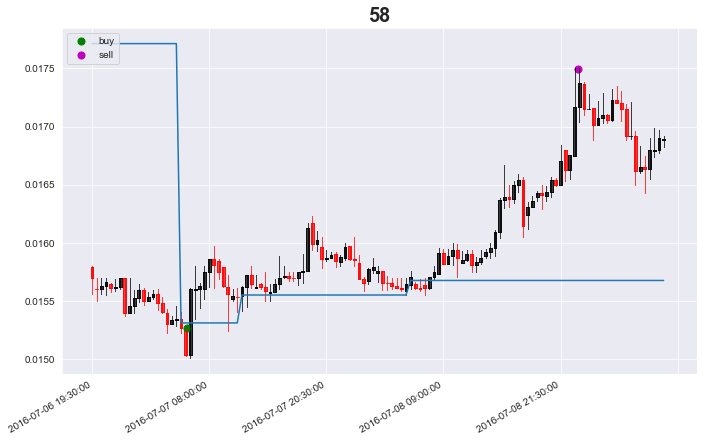

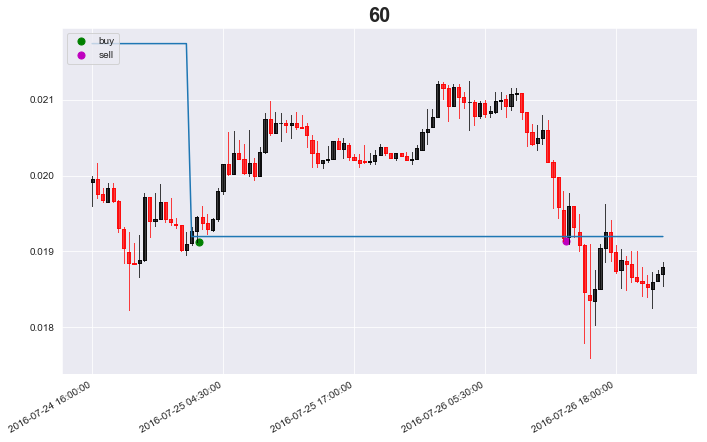

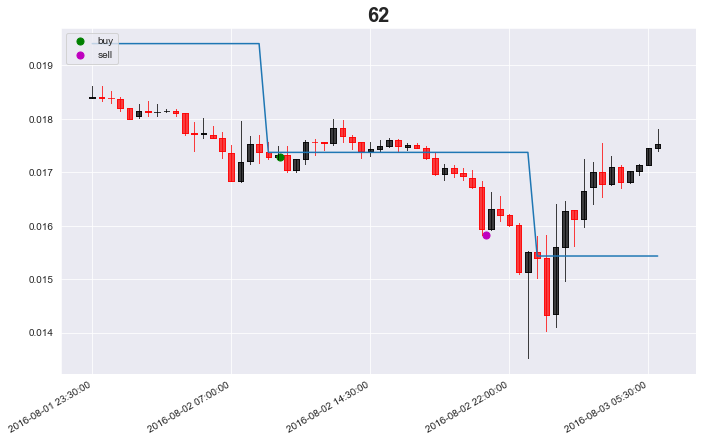

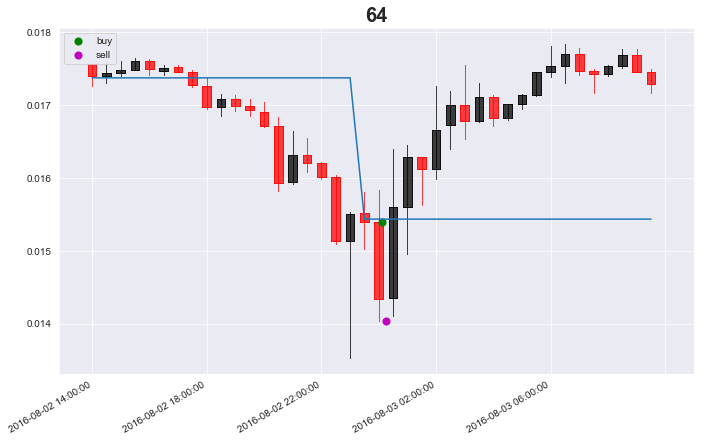

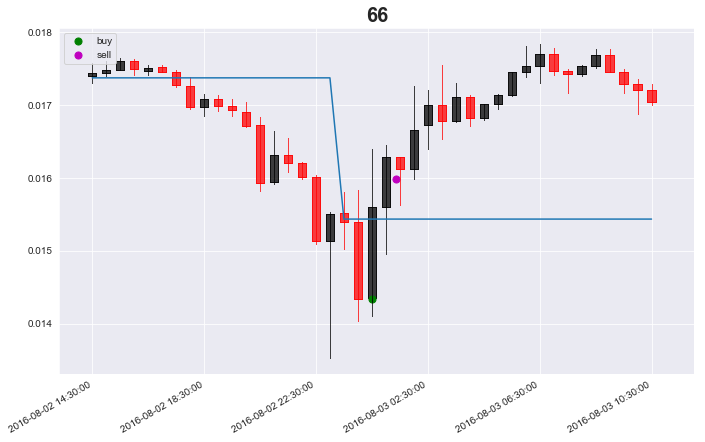

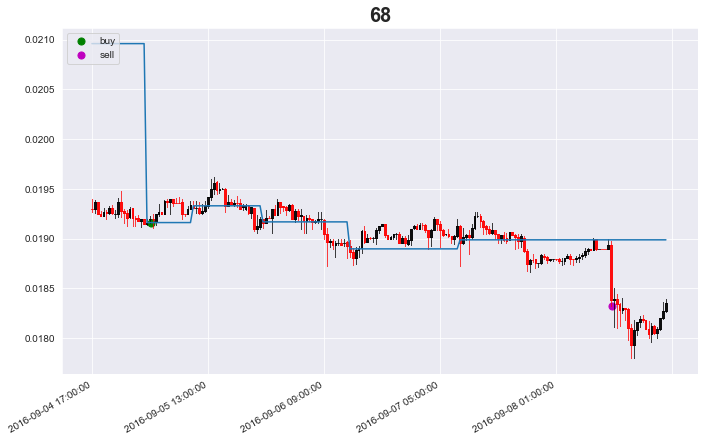

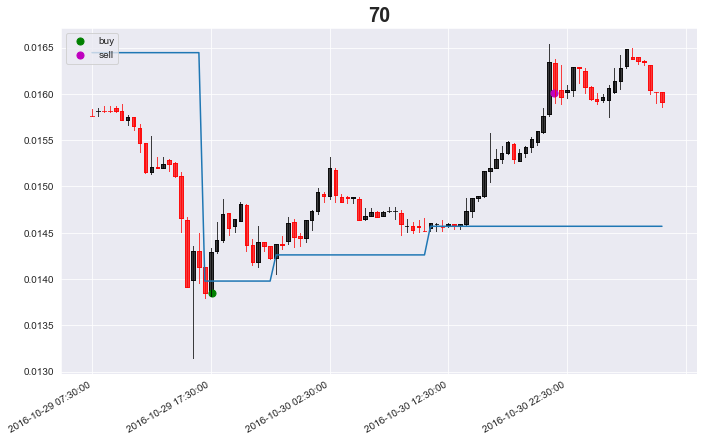

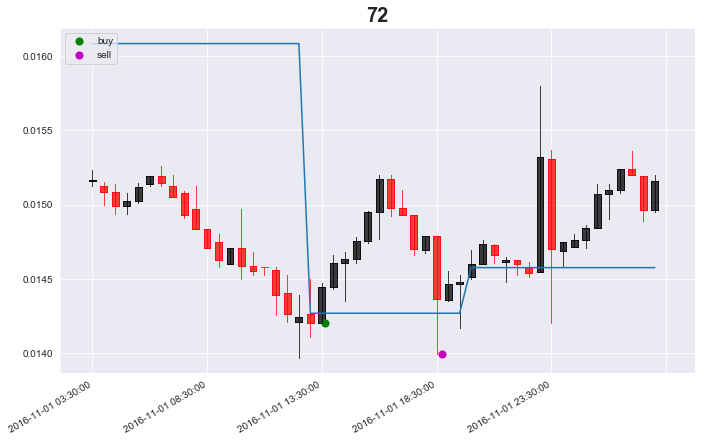

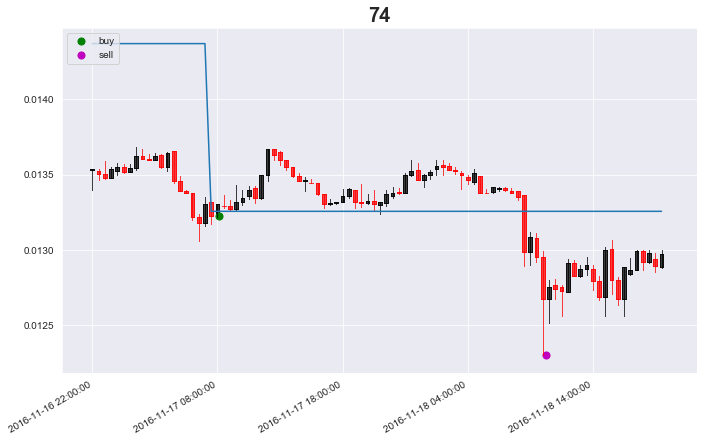

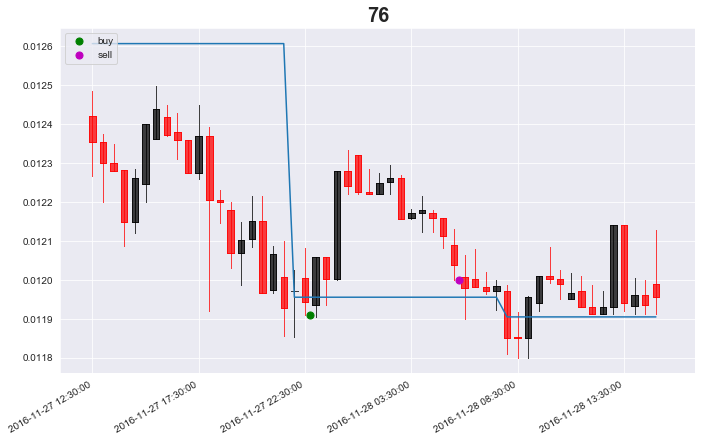

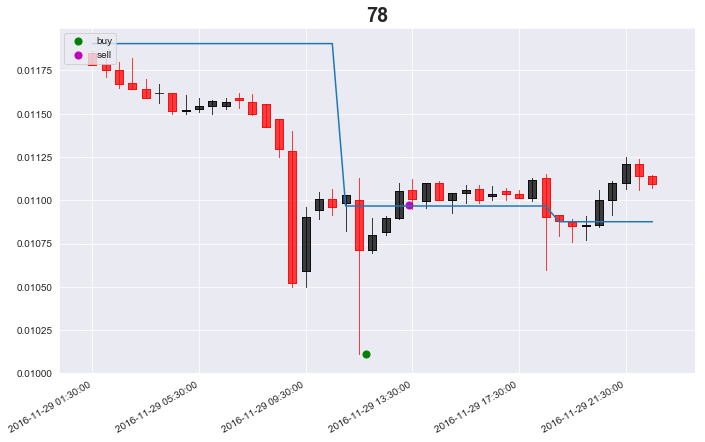

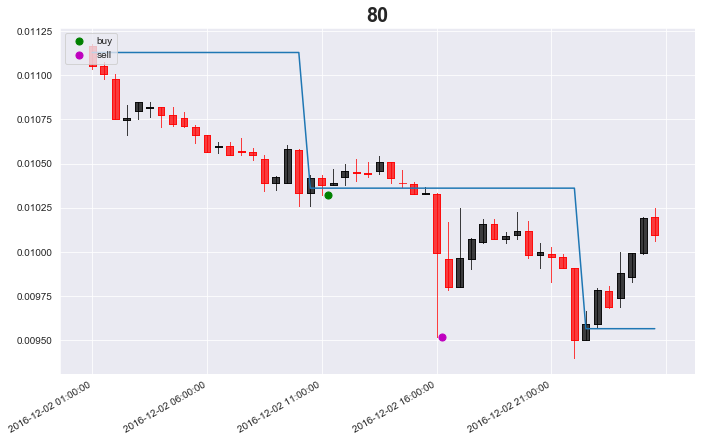

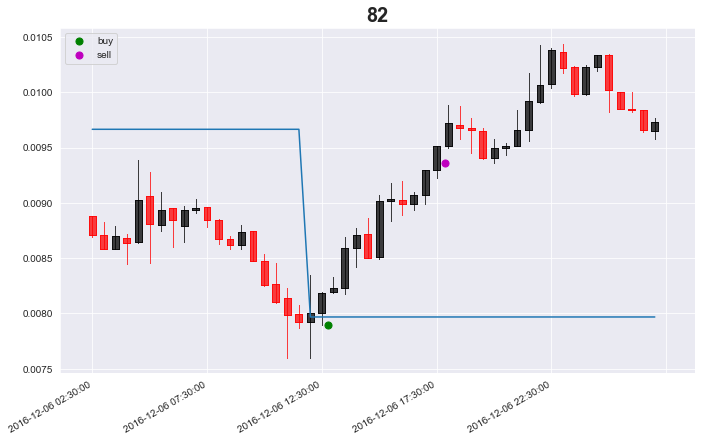

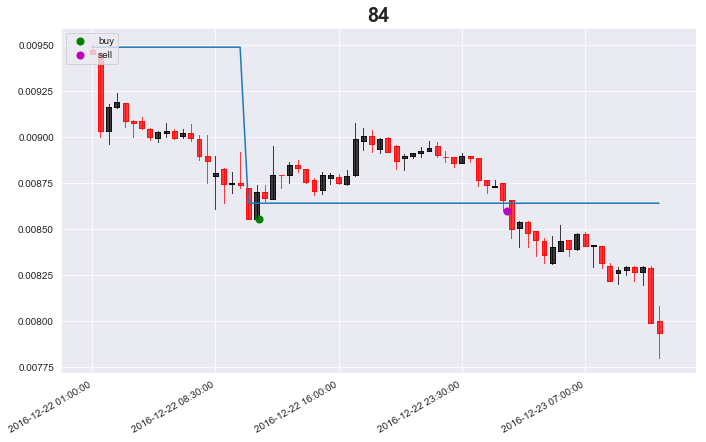

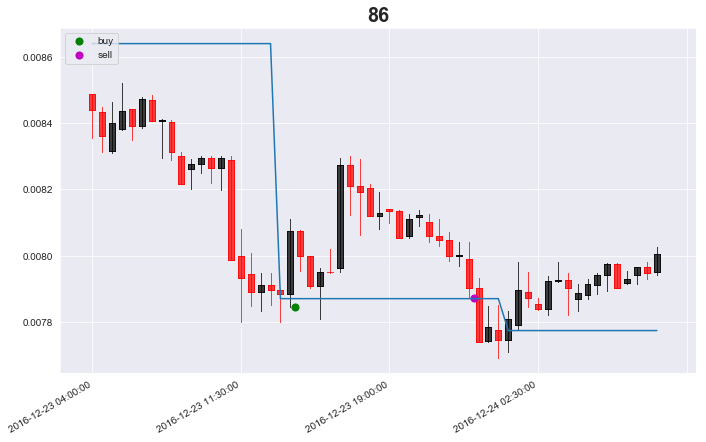

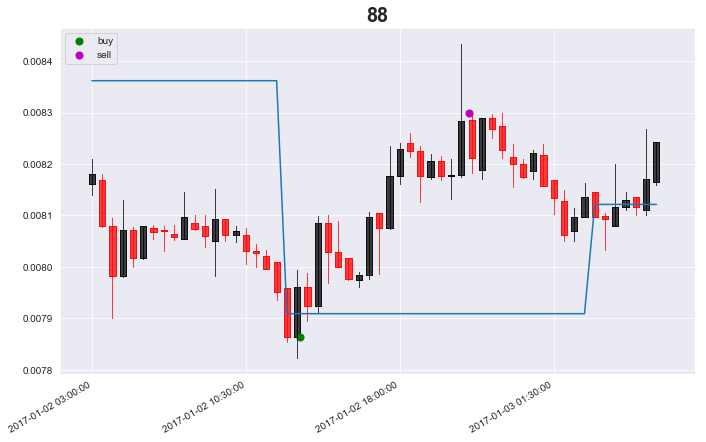

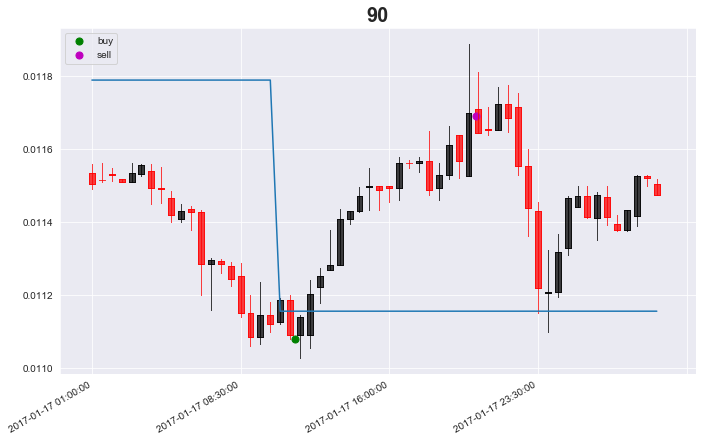

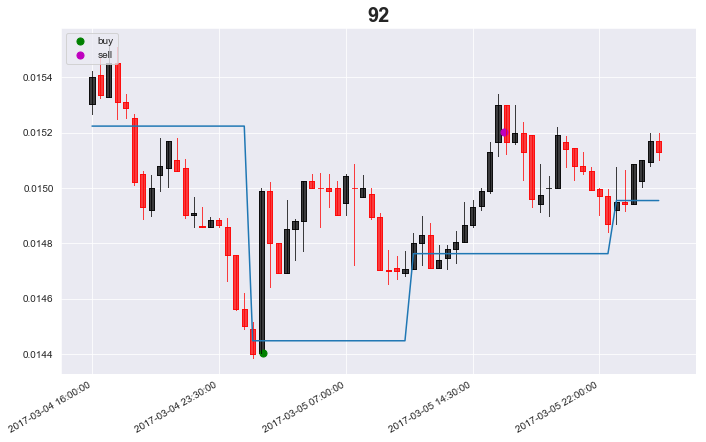

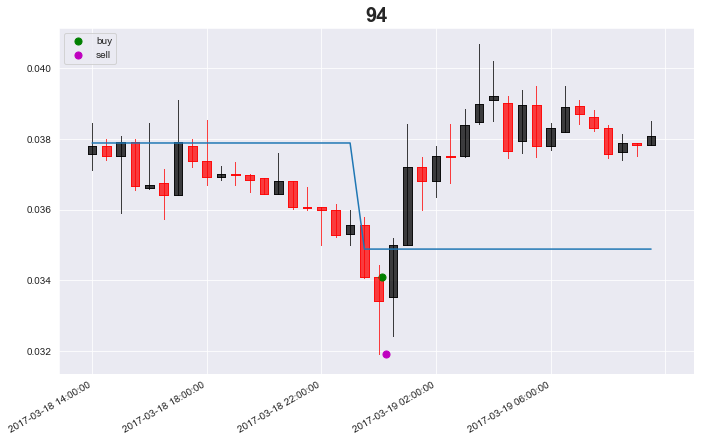

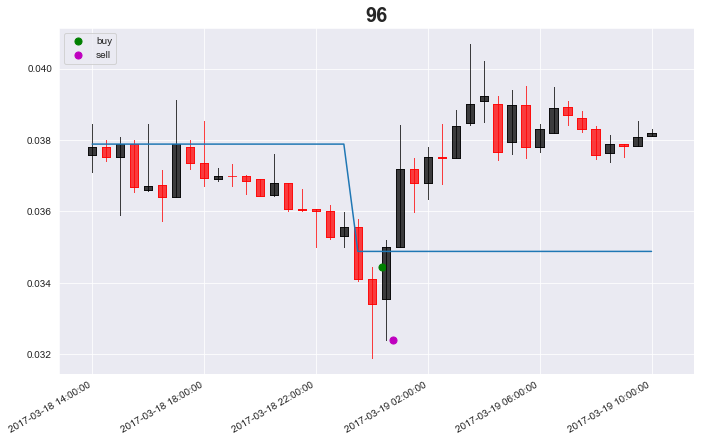

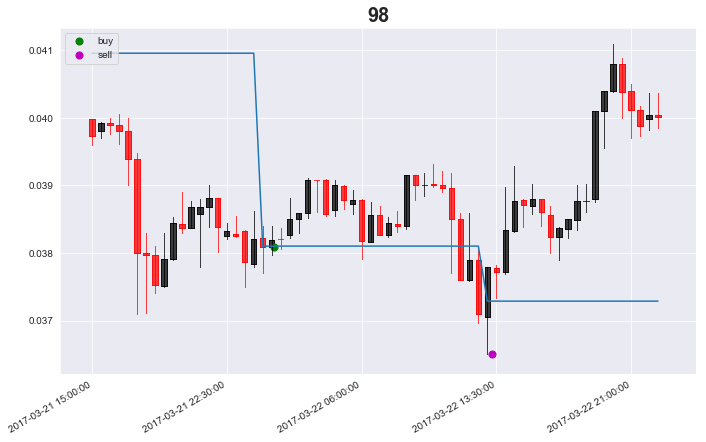

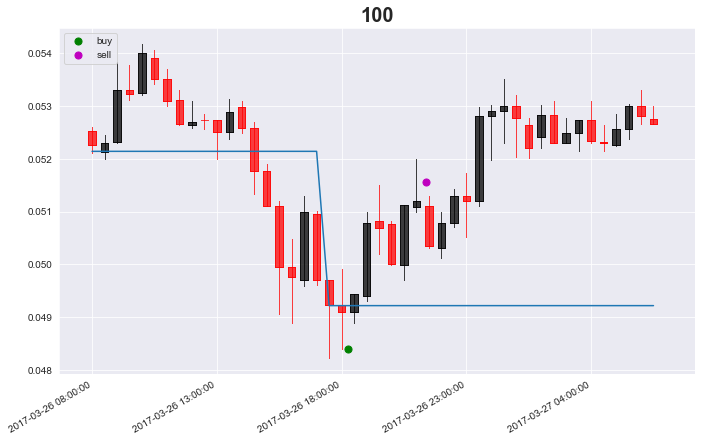

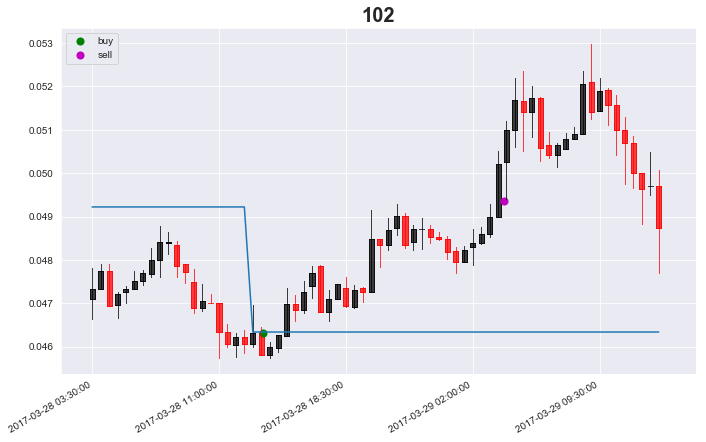

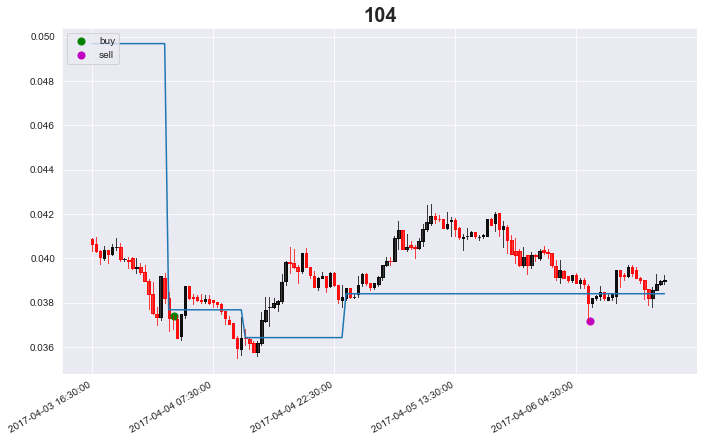

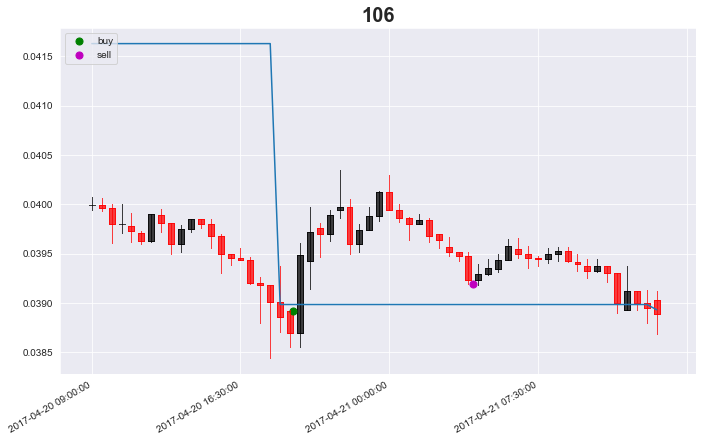

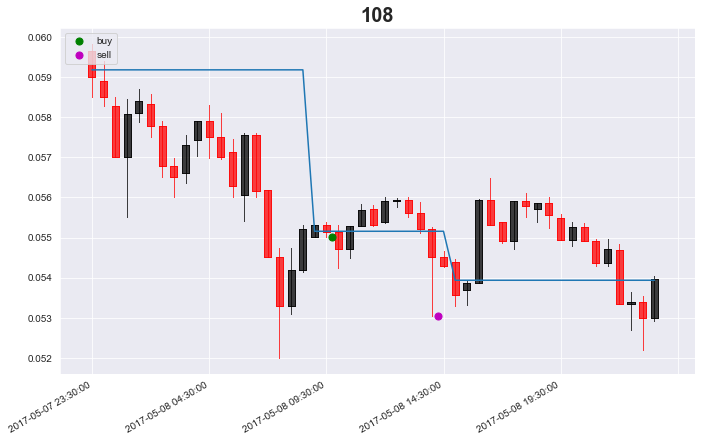

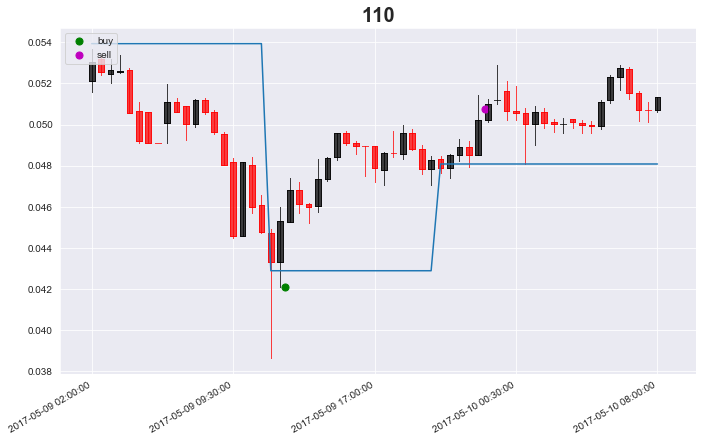

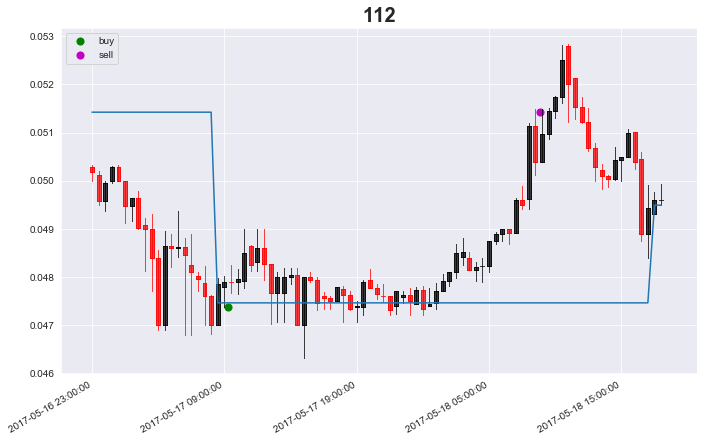

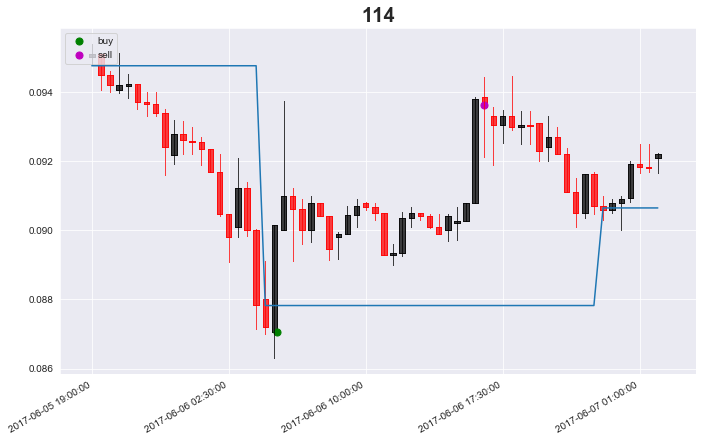

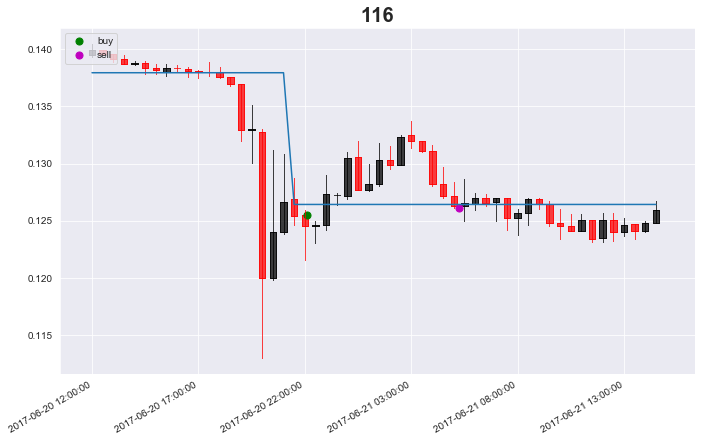

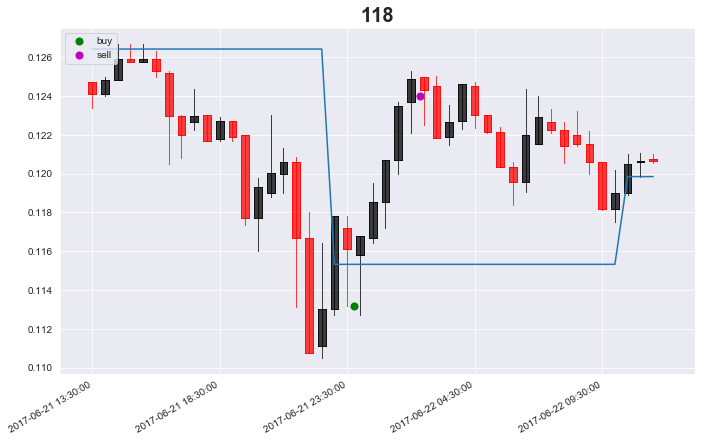

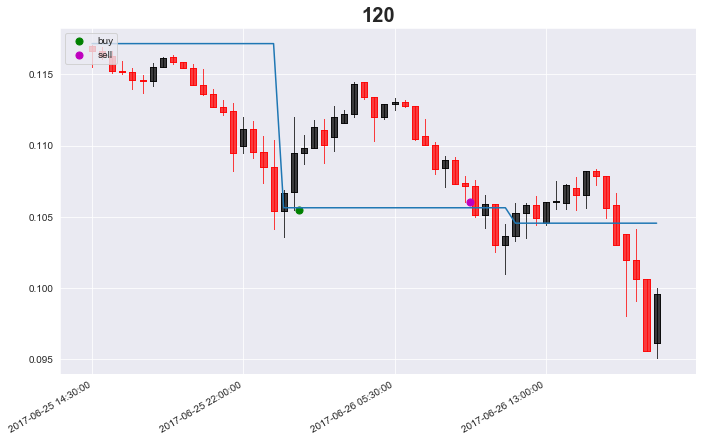

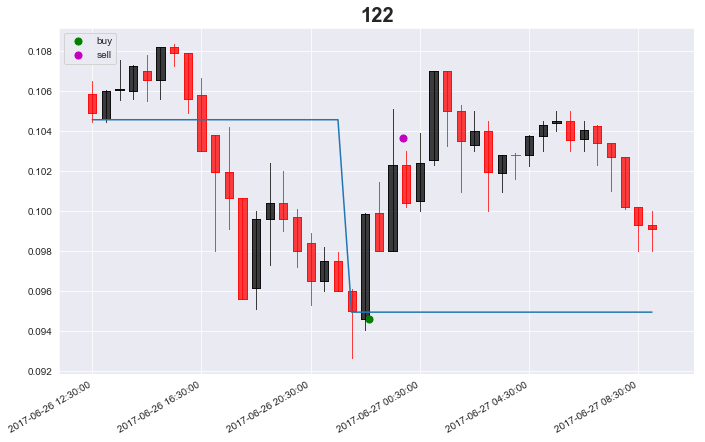

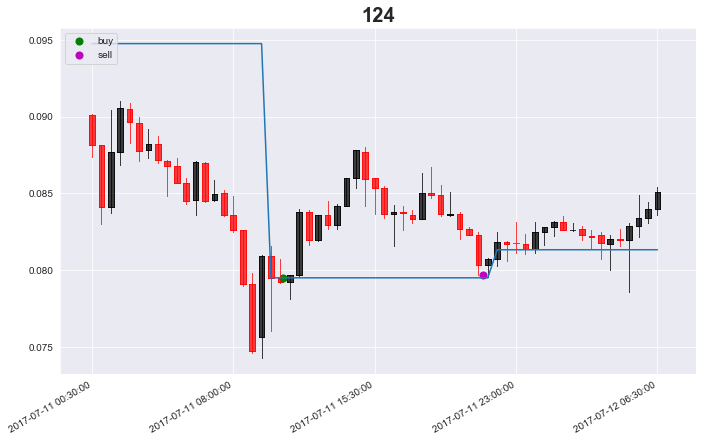

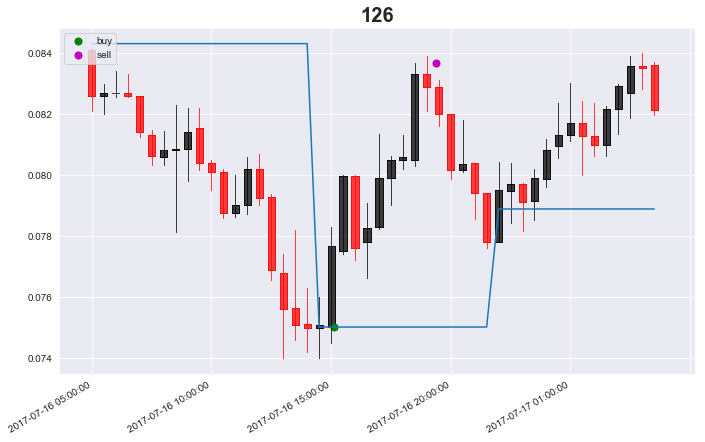

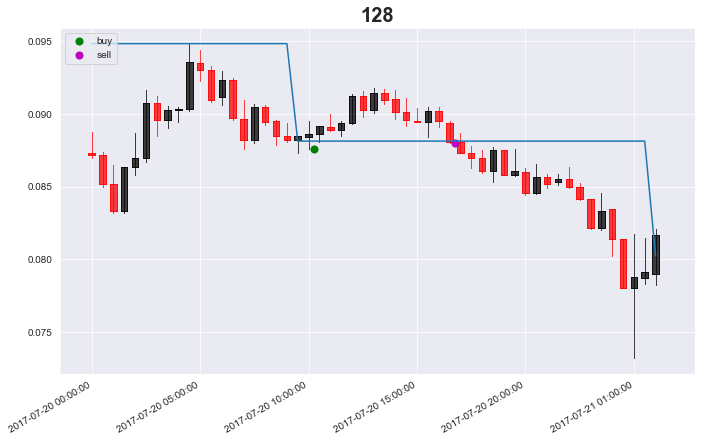

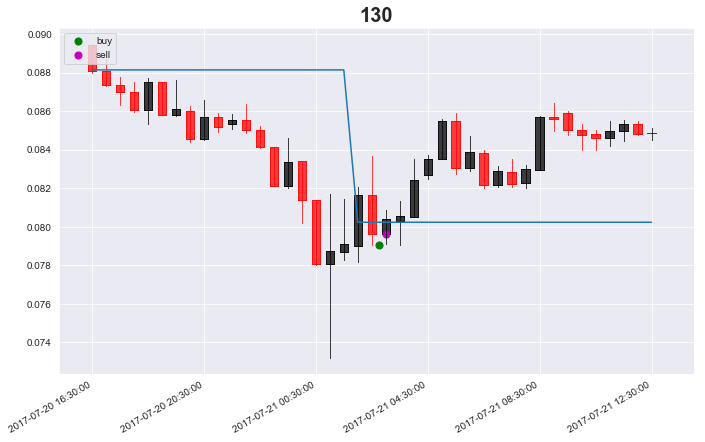

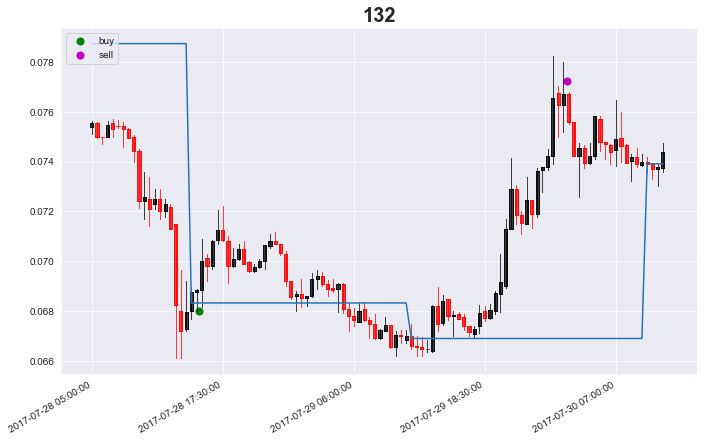

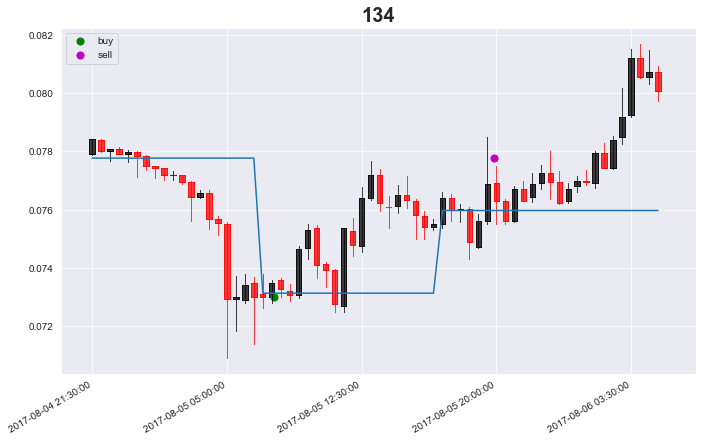

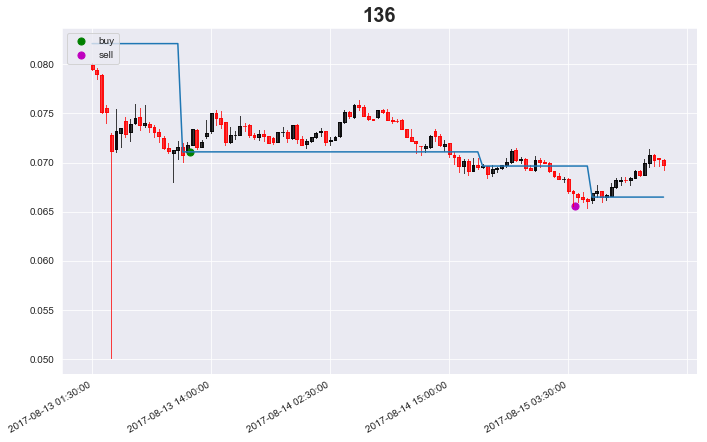

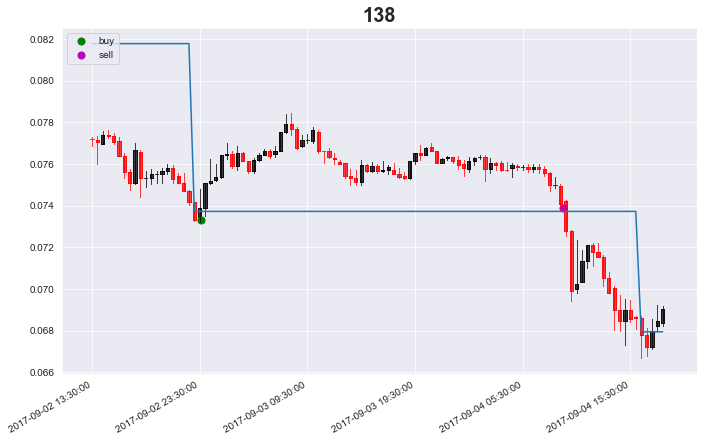

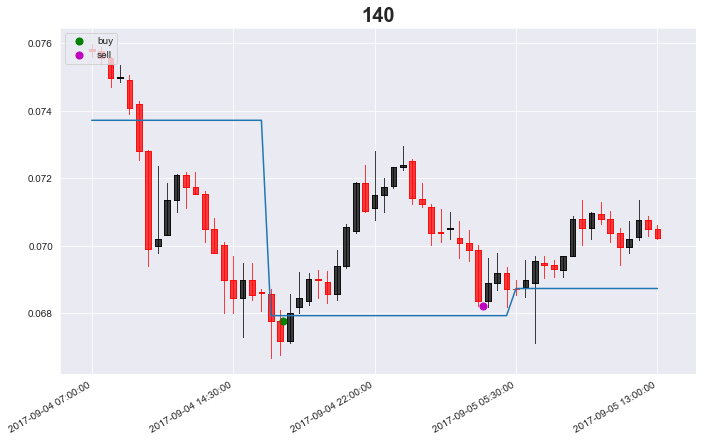

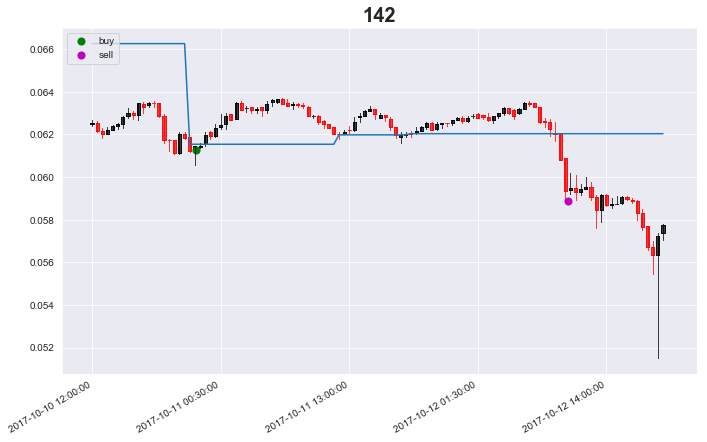

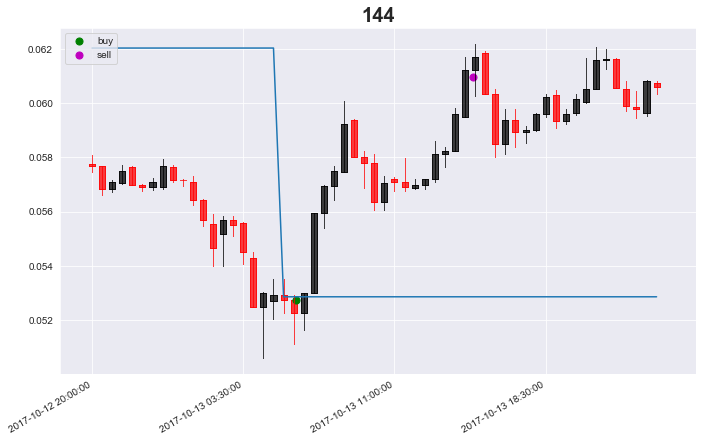

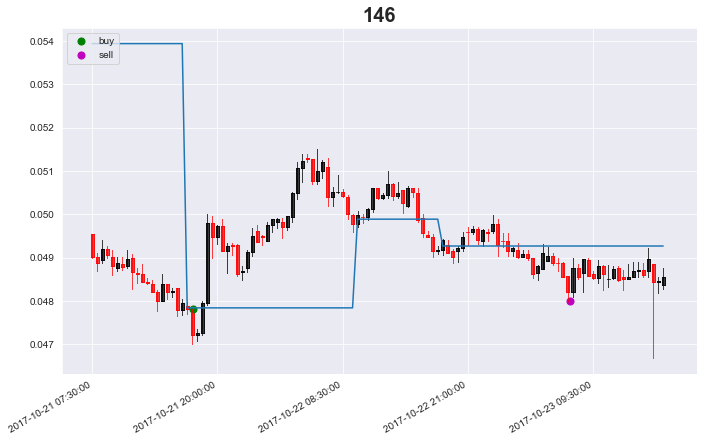

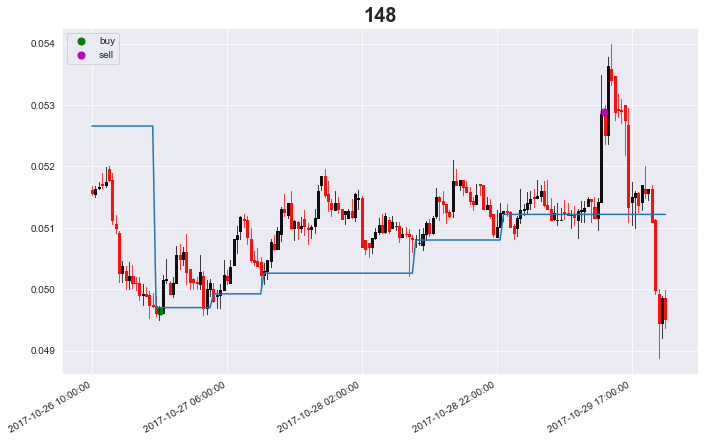

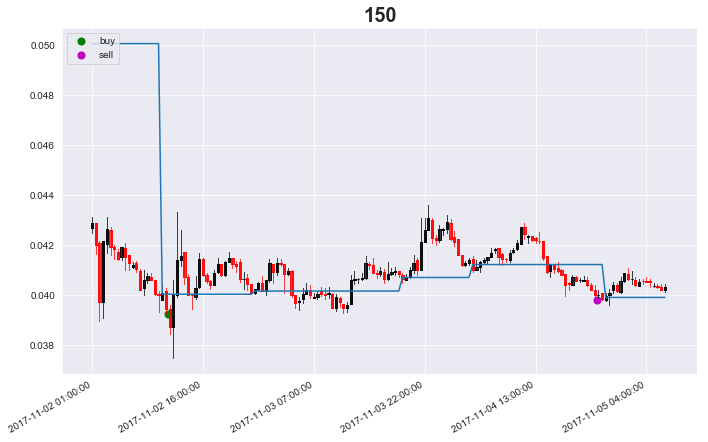

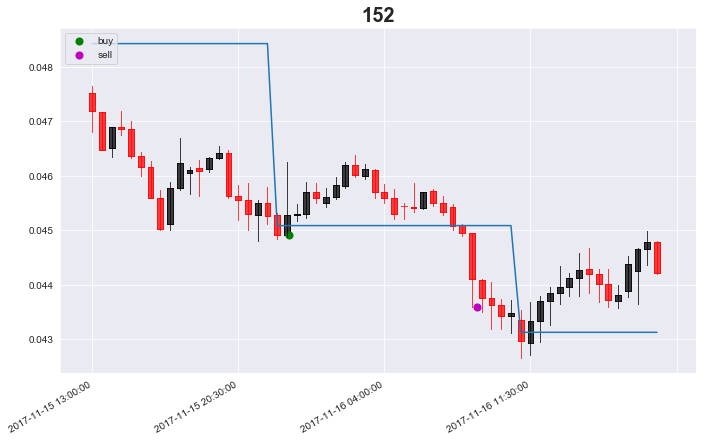

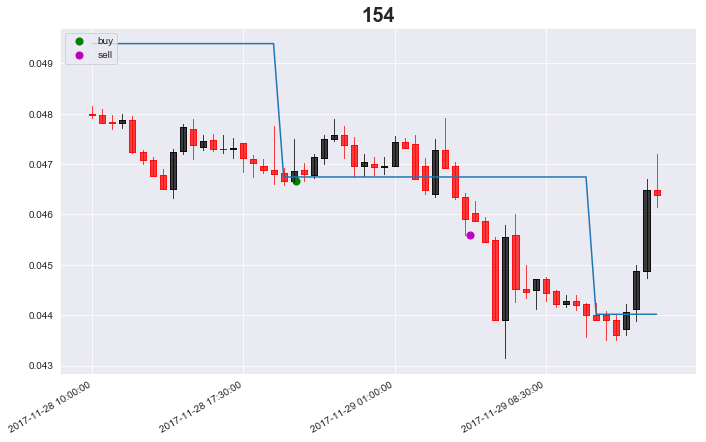

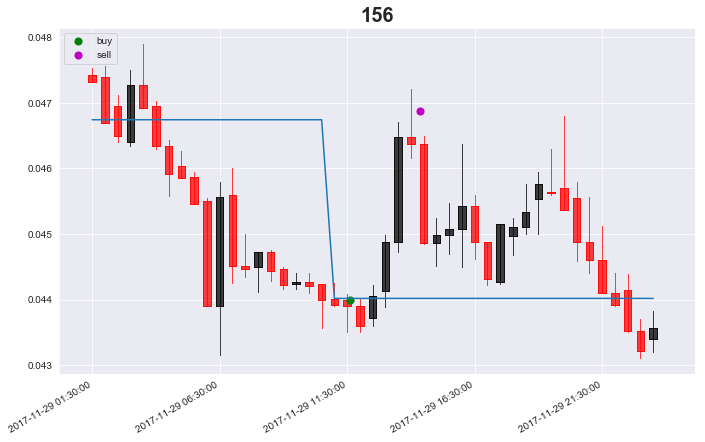

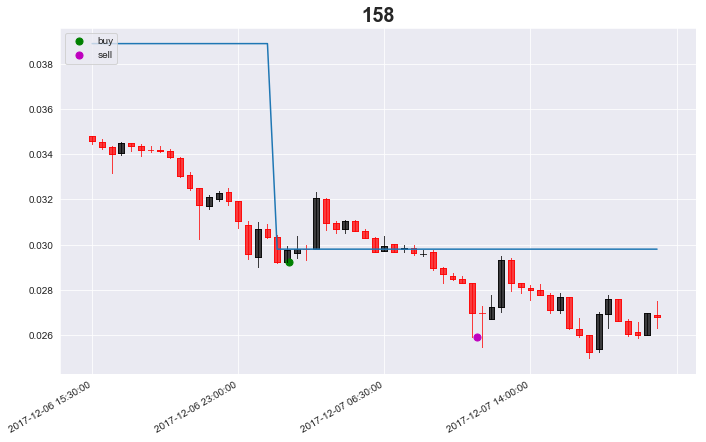

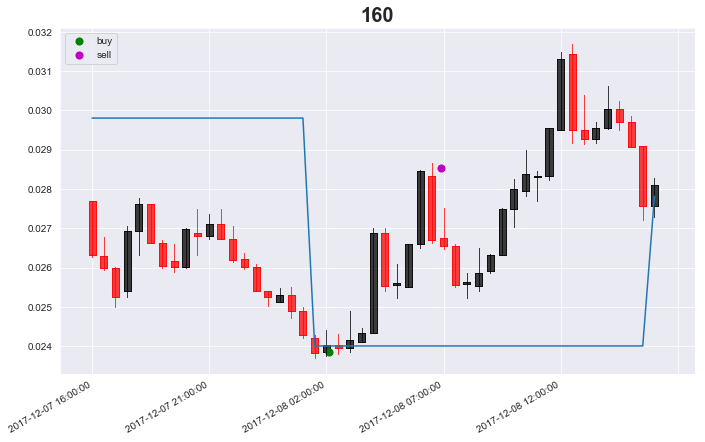

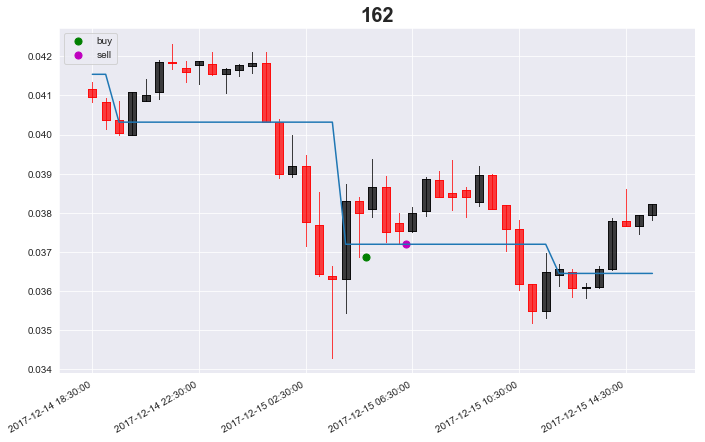

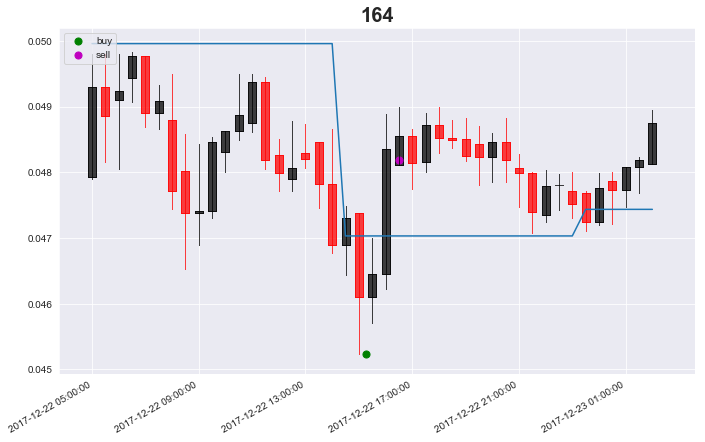

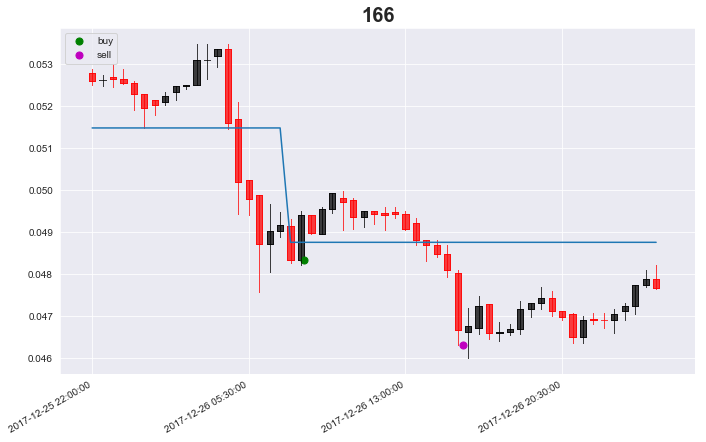

In [75]:
pair = 'BTC_ETH'
data = train_dict[pair]
data['support'] = supports_for_data_dict[pair][12]
# plot_candles(data)
for i in range(0, len(stats.transactions), 2):
    plot_transactions(data, stats.transactions[i:i+2], 'support', 20)
    plt.title(i, fontproperties=title_font)

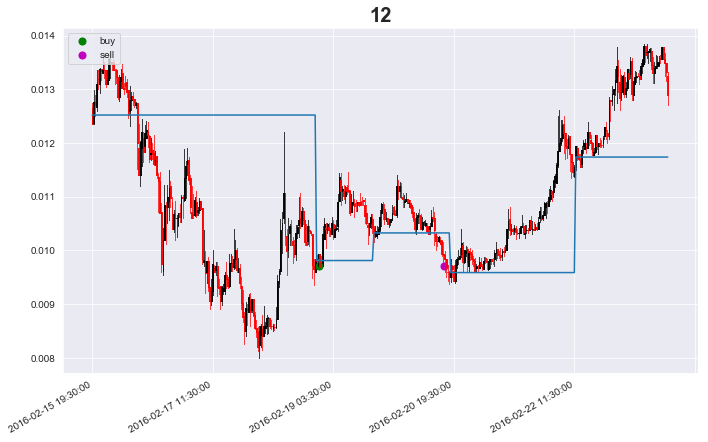

In [77]:
pair = 'BTC_ETH'
data = train_dict[pair]
data['support'] = supports_for_data_dict[pair][12]
# plot_candles(data)
for i in [12]:
    plot_transactions(data, stats.transactions[i:i+2], 'support', 150)
    plt.title(i, fontproperties=title_font)